# This is an all in one safe result...the where I tried alexnet with only 80 sample points .... which is the minimum number samples each has because there is one family of malware which has only 80 samples...

# this is to ensure that the augumentation doesnt mess with the Random Forest ... which is the case in some places I saw over the internet..

# I did this to try the method without any augumentation


## this notebook includes both feature extraction and classification

## it will be used other places



## link to original dataset https://mega.nz/file/ZN8HDQoI#Shh3gwXYJoB_1HNBoJ1LeQdhe-JZ_2zJjn62MXhObgk

In [12]:
from torchvision import models
import torch
from PIL import Image
from skimage import io, transform
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import os
from sklearn import metrics


# Load alexnet..from the internet..but for others I locally save models

In [21]:
alexnet = models.alexnet(pretrained=True) # This will download the weights for the network first time it is run!

In [22]:
extractor=torch.nn.Sequential(alexnet.features, torch.nn.Flatten())

# my local dataset path to original

In [ ]:
dataset='../malimg_paper_dataset_imgs'

In [ ]:
transform = transforms.Compose([        # Defining a variable transforms
 transforms.Resize(224),                # Resize the image to 256×256 pixels
 transforms.ToTensor(),                 # Convert the image to PyTorch Tensor data type
 transforms.Normalize(                  # Normalize the image
 mean=[0.485, 0.456, 0.406],            # Mean and std of image as also used when training the network
 std=[0.229, 0.224, 0.225]      
 )])

# my local dataset where I intend to save the extracted features

# Link to this dataset https://mega.nz/file/AEVngSoY#Rve-XEpgY_FRUX3xnDh7IixNZM_KLL4MWRe7UyIcoUw

In [ ]:
target='./features_only_80'

In [ ]:
os.mkdir(target)

In [ ]:
rounds=0
for (root,dirs,files) in  os.walk(dataset, topdown=True):
    
    if len(files)== 0:
        continue

    dirname = root.split(os.path.sep)[-1]
    
    print( "doing for ..  ", dirname," ", end='')
    
    counter+=1
    counter=0
    os.mkdir(target+'/'+dirname)
    for i in files[:80]:                        
        img=Image.open(root+'/'+i)
        img=img.resize((224,224))        
        
        # channel
        img=np.stack((img,)*3, axis=-1) # stack  to create channels
        img=Image.fromarray(img)
        
        img=transform(img) # transform to tensor
        img= torch.unsqueeze(img,0) 
        feature=extractor(img) 
        torch.save(feature, target+'/'+dirname+'/'+str(counter)+i+'.pt')
        
    print("done for ", dirname)
    rounds+=1
    


    


# classification by Random Forest

In [13]:
from torch.utils.data import DataLoader,Dataset
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import skimage.io as io
from torchsummary import summary
from tqdm import tqdm

In [14]:
x=[]
y=[]

for (root,dirs,files) in  os.walk('./features80', topdown=True):
    
    if len(files)== 0:
        continue

    dirname = root.split(os.path.sep)[-1]
#     print(dirname)
    for i in files:
#         tensor_=torch.load(root+'/'+i)
        x.append(torch.load(root+'/'+i))
        y.append(dirname)
        
    

In [15]:

le = preprocessing.LabelEncoder()
le.fit(y)
labels_encoded = le.transform(y)
y_train = labels_encoded
x_np = [i.detach().numpy()[0] for i in x]

In [16]:
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(x_np, y_train, test_size=0.2)

In [18]:
# Train the model on training data
RF_model.fit(X_train, Y_train)


RandomForestClassifier(n_estimators=50, random_state=42)

In [19]:
pred = RF_model.predict(X_test)

In [20]:
print ("Accuracy = ", metrics.accuracy_score(Y_test, pred))

Accuracy =  0.945


<AxesSubplot:>

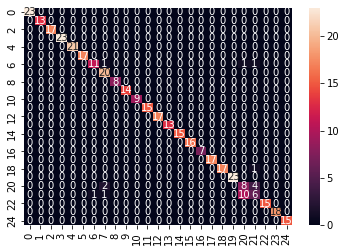

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(Y_test, pred)
#print(cm)
sns.heatmap(cm, annot=True )